In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Input, Concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model

In [4]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [123]:
X_train = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/text_seq_data/word_seq_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/text_seq_data/word_seq_test.csv')
X_valid = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/text_seq_data/word_seq_valid.csv')

y_train = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/label_seq_data/train_label.csv')
y_test = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/label_seq_data/test_label.csv')
y_valid = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/label_seq_data/valid_label.csv')

vocab_size = int(np.loadtxt('/content/drive/MyDrive/ML_Project/data/liar_dataset/vocab_size_text.txt'))

In [6]:
print(vocab_size)

14957


In [7]:
X_train.shape, X_test.shape, X_valid.shape

((9465, 50), (1167, 50), (1183, 50))

# Multiclass

In [124]:
abs_multiclass = dict()
abs_multiclass[-3] = 0
abs_multiclass[-2]=1
abs_multiclass[-1]=2
abs_multiclass[1]=3
abs_multiclass[2]=4
abs_multiclass[3]=5

In [125]:
y_train = y_train.replace({'label': abs_multiclass})
y_test = y_test.replace({'label': abs_multiclass})
y_valid = y_valid.replace({'label': abs_multiclass})

## Text only

### LSTM

The LSTM model includes:
- a layer of embeddings, 
- Dropout(0.4), 
- LSTM(4), 
- Dropout(0.4), 
- fully connected layer with 100 units and activation function ReLu,
- Dropout(0.5) and fully connected layer with activation function sigmoid. 

LSTM network was trained on full-text data using the first 1200 words of the articles (because of memory limitations).

In [37]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, input_length=50, output_dim=4))
model.add(Dropout(rate=0.4))
model.add(LSTM(units=4))
model.add(Dropout(rate=0.4))
model.add(Dense(units=100,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=6, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 4)             59828     
                                                                 
 dropout_15 (Dropout)        (None, 50, 4)             0         
                                                                 
 lstm_5 (LSTM)               (None, 4)                 144       
                                                                 
 dropout_16 (Dropout)        (None, 4)                 0         
                                                                 
 dense_10 (Dense)            (None, 100)               500       
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 6)                

In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [39]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=[X_valid, y_valid],
    epochs = 5
)

Epoch 1/5
296/296 [==============================] - 7s 15ms/step - loss: 1.7631 - accuracy: 0.2038 - val_loss: 1.7569 - val_accuracy: 0.1970
Epoch 2/5
296/296 [==============================] - 4s 13ms/step - loss: 1.7534 - accuracy: 0.2070 - val_loss: 1.7542 - val_accuracy: 0.2113
Epoch 3/5
296/296 [==============================] - 4s 13ms/step - loss: 1.7340 - accuracy: 0.2222 - val_loss: 1.7224 - val_accuracy: 0.2460
Epoch 4/5
296/296 [==============================] - 4s 13ms/step - loss: 1.6838 - accuracy: 0.2576 - val_loss: 1.7242 - val_accuracy: 0.2527
Epoch 5/5
296/296 [==============================] - 4s 13ms/step - loss: 1.6378 - accuracy: 0.2840 - val_loss: 1.7448 - val_accuracy: 0.2426


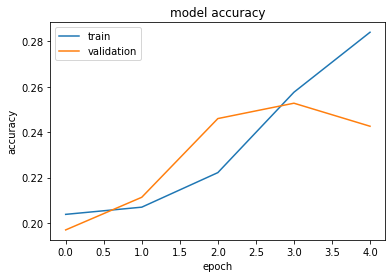

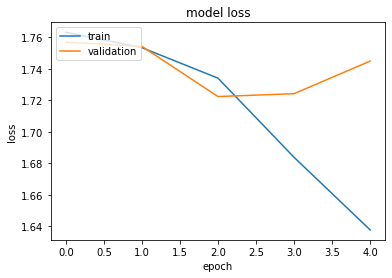

In [40]:
plot_history(history)

In [41]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 0s 6ms/step - loss: 1.7379 - accuracy: 0.2579
Test score: 1.7379460334777832
Test accuracy: 0.2579263150691986


In [42]:
y_probas = model.predict(X_test)
y_pred = y_probas.argmax(axis=-1)

In [43]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.26      0.47      0.33       222
           2       0.60      0.05      0.09       195
           3       0.26      0.19      0.22       246
           4       0.25      0.64      0.36       222
           5       1.00      0.00      0.00       199

    accuracy                           0.26      1167
   macro avg       0.39      0.22      0.17      1167
weighted avg       0.42      0.26      0.19      1167



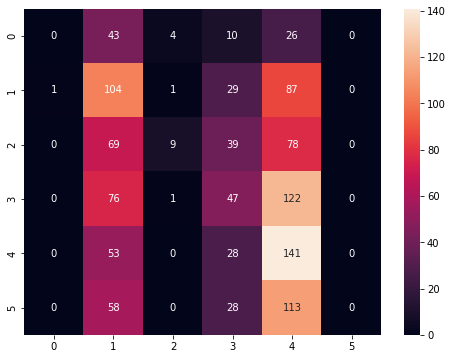

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Bi-LSTM

The Bi-LSTM model includes:
- a layer of embeddings, 
- Dropout(0.4), 
- Bi-LSTM(4), 
- Dropout(0.4), 
- fully connected layer with 100 units and activation function ReLu,
- Dropout(0.5) and fully connected layer with activation function sigmoid. 

Bi-LSTM network was trained on full-text data using the first 1200 words of the articles (because of memory limitations).

In [45]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, input_length=50, output_dim=4))
model.add(Dropout(rate=0.4))
model.add(Bidirectional(LSTM(units=4)))
model.add(Dropout(rate=0.4))
model.add(Dense(units=100,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=6, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 4)             59828     
                                                                 
 dropout_18 (Dropout)        (None, 50, 4)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 8)                288       
 l)                                                              
                                                                 
 dropout_19 (Dropout)        (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 100)               900       
                                                                 
 dropout_20 (Dropout)        (None, 100)               0         
                                                      

In [46]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [47]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=[X_valid, y_valid],
    epochs = 5
)

Epoch 1/5
296/296 [==============================] - 11s 26ms/step - loss: 1.7644 - accuracy: 0.1982 - val_loss: 1.7577 - val_accuracy: 0.1970
Epoch 2/5
296/296 [==============================] - 7s 23ms/step - loss: 1.7566 - accuracy: 0.2044 - val_loss: 1.7580 - val_accuracy: 0.1970
Epoch 3/5
296/296 [==============================] - 7s 23ms/step - loss: 1.7485 - accuracy: 0.2144 - val_loss: 1.7489 - val_accuracy: 0.2096
Epoch 4/5
296/296 [==============================] - 7s 23ms/step - loss: 1.7195 - accuracy: 0.2449 - val_loss: 1.7396 - val_accuracy: 0.2198
Epoch 5/5
296/296 [==============================] - 7s 23ms/step - loss: 1.6618 - accuracy: 0.2853 - val_loss: 1.7509 - val_accuracy: 0.2409


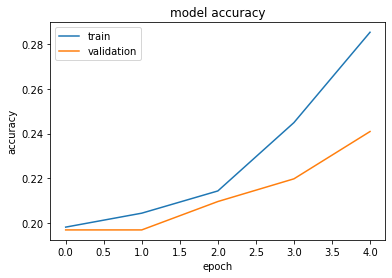

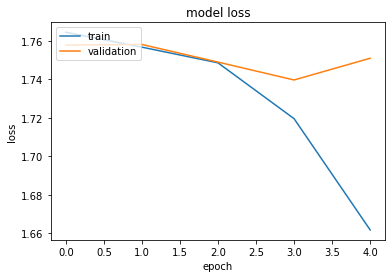

In [56]:
plot_history(history)

In [48]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 0s 9ms/step - loss: 1.7523 - accuracy: 0.2194
Test score: 1.752320647239685
Test accuracy: 0.2193658947944641


In [49]:
y_probas = model.predict(X_test)
y_pred = y_probas.argmax(axis=-1)

In [54]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.23      0.53      0.32       222
           2       0.22      0.23      0.22       195
           3       0.18      0.13      0.15       246
           4       0.22      0.27      0.24       222
           5       0.50      0.01      0.02       199

    accuracy                           0.22      1167
   macro avg       0.22      0.19      0.16      1167
weighted avg       0.25      0.22      0.18      1167



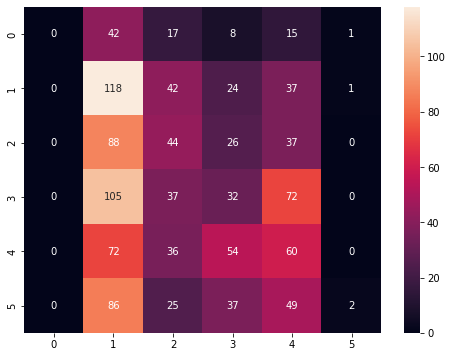

In [55]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Speaker, Party, Text Data

In [58]:
speaker_train = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/speaker_data/train_speaker.csv')
speaker_test = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/speaker_data/test_speaker.csv')
speaker_valid = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/speaker_data/valid_speaker.csv')

In [59]:
party_train = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/party_data/train_party.csv')
party_test = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/party_data/test_party.csv')
party_valid = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/party_data/valid_party.csv')

In [60]:
speaker_vocab_size = max(list(speaker_train['speaker']) + list(speaker_test['speaker']) + list(speaker_valid['speaker']))+1
party_vocab_size = max(list(party_train['party']) + list(party_test['party']) + list(party_valid['party']))+1
text_vocab_size = vocab_size

### LSTM

In [126]:
speaker_input = Input(shape=(1,))
speaker_features = (Embedding(input_dim=speaker_vocab_size, input_length=1, output_dim=100))(speaker_input)
speaker_features = Dropout(rate=0.4)(speaker_features)
speaker_features = LSTM(units=4)(speaker_features)

party_input = Input(shape=(1,))
party_features = (Embedding(input_dim=party_vocab_size, input_length=1, output_dim=100))(party_input)
party_features = Dropout(rate=0.4)(party_features)
party_features = LSTM(units=4)(party_features)

text_input = Input(shape=(50,))
text_features = (Embedding(input_dim=text_vocab_size, input_length=50, output_dim=100))(text_input)
text_features = Dropout(rate=0.4)(text_features)
text_features = LSTM(units=4)(text_features)

x = Concatenate()([speaker_features, party_features, text_features])
x = Dropout(rate=0.5)(x)
model_output = Dense(units=6, activation='sigmoid')(x)

model = Model([speaker_input, party_input, text_input], model_output, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 1, 100)       306600      ['input_17[0][0]']               
                                                                                              

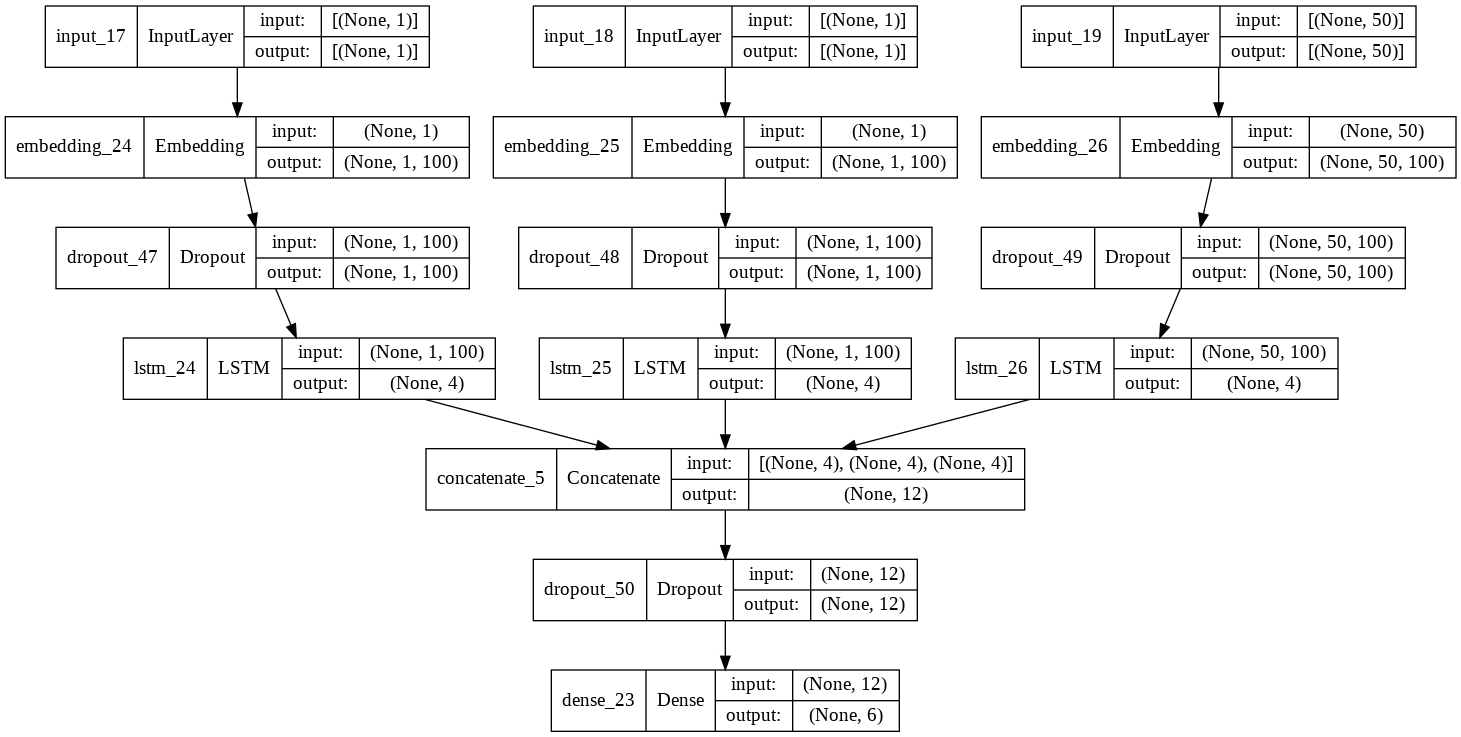

In [127]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [128]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [129]:
history = model.fit(
    [speaker_train, party_train, X_train], 
    y_train, 
    validation_data=[[speaker_valid, party_valid, X_valid], y_valid],
    epochs = 5
)

Epoch 1/5
296/296 [==============================] - 13s 25ms/step - loss: 1.7613 - accuracy: 0.2229 - val_loss: 1.7322 - val_accuracy: 0.2477
Epoch 2/5
296/296 [==============================] - 6s 20ms/step - loss: 1.7023 - accuracy: 0.2572 - val_loss: 1.6987 - val_accuracy: 0.2697
Epoch 3/5
296/296 [==============================] - 6s 20ms/step - loss: 1.6078 - accuracy: 0.3255 - val_loss: 1.6887 - val_accuracy: 0.2654
Epoch 4/5
296/296 [==============================] - 6s 20ms/step - loss: 1.5041 - accuracy: 0.3908 - val_loss: 1.7125 - val_accuracy: 0.2418
Epoch 5/5
296/296 [==============================] - 6s 20ms/step - loss: 1.3949 - accuracy: 0.4395 - val_loss: 1.7561 - val_accuracy: 0.2375


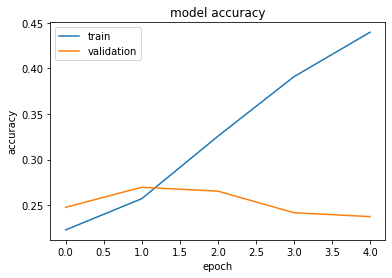

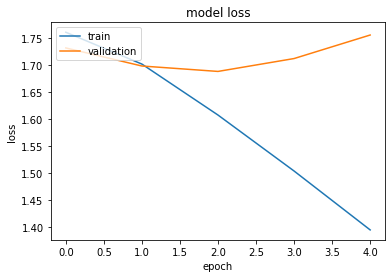

In [130]:
plot_history(history)

In [131]:
score, acc = model.evaluate([speaker_test, party_test, X_test], y_test)
print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 0s 8ms/step - loss: 1.7606 - accuracy: 0.2416
Test score: 1.7605700492858887
Test accuracy: 0.24164524674415588


In [132]:
y_probas = model.predict([speaker_test, party_test, X_test])
y_pred = y_probas.argmax(axis=-1)

In [133]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.24      0.11      0.15        83
           1       0.26      0.35      0.30       222
           2       0.17      0.15      0.16       195
           3       0.25      0.31      0.28       246
           4       0.25      0.30      0.27       222
           5       0.26      0.11      0.15       199

    accuracy                           0.24      1167
   macro avg       0.24      0.22      0.22      1167
weighted avg       0.24      0.24      0.23      1167



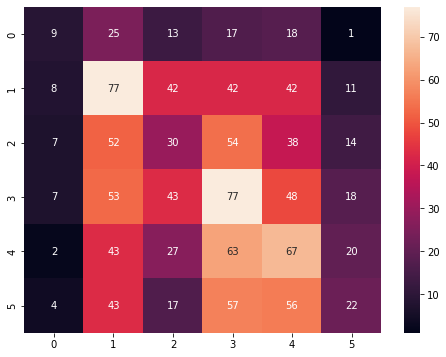

In [134]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Bi-LSTM

In [135]:
speaker_input = Input(shape=(1,))
speaker_features = (Embedding(input_dim=speaker_vocab_size, input_length=1, output_dim=100))(speaker_input)
speaker_features = Dropout(rate=0.4)(speaker_features)
speaker_features = Bidirectional(LSTM(units=4))(speaker_features)

party_input = Input(shape=(1,))
party_features = (Embedding(input_dim=party_vocab_size, input_length=1, output_dim=100))(party_input)
party_features = Dropout(rate=0.4)(party_features)
party_features = Bidirectional(LSTM(units=4))(party_features)

text_input = Input(shape=(50,))
text_features = (Embedding(input_dim=text_vocab_size, input_length=50, output_dim=100))(text_input)
text_features = Dropout(rate=0.4)(text_features)
text_features = Bidirectional(LSTM(units=4))(text_features)

x = Concatenate()([speaker_features, party_features, text_features])
x = Dropout(rate=0.5)(x)
model_output = Dense(units=6, activation='sigmoid')(x)

model = Model([speaker_input, party_input, text_input], model_output, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_27 (Embedding)       (None, 1, 100)       306600      ['input_20[0][0]']               
                                                                                              

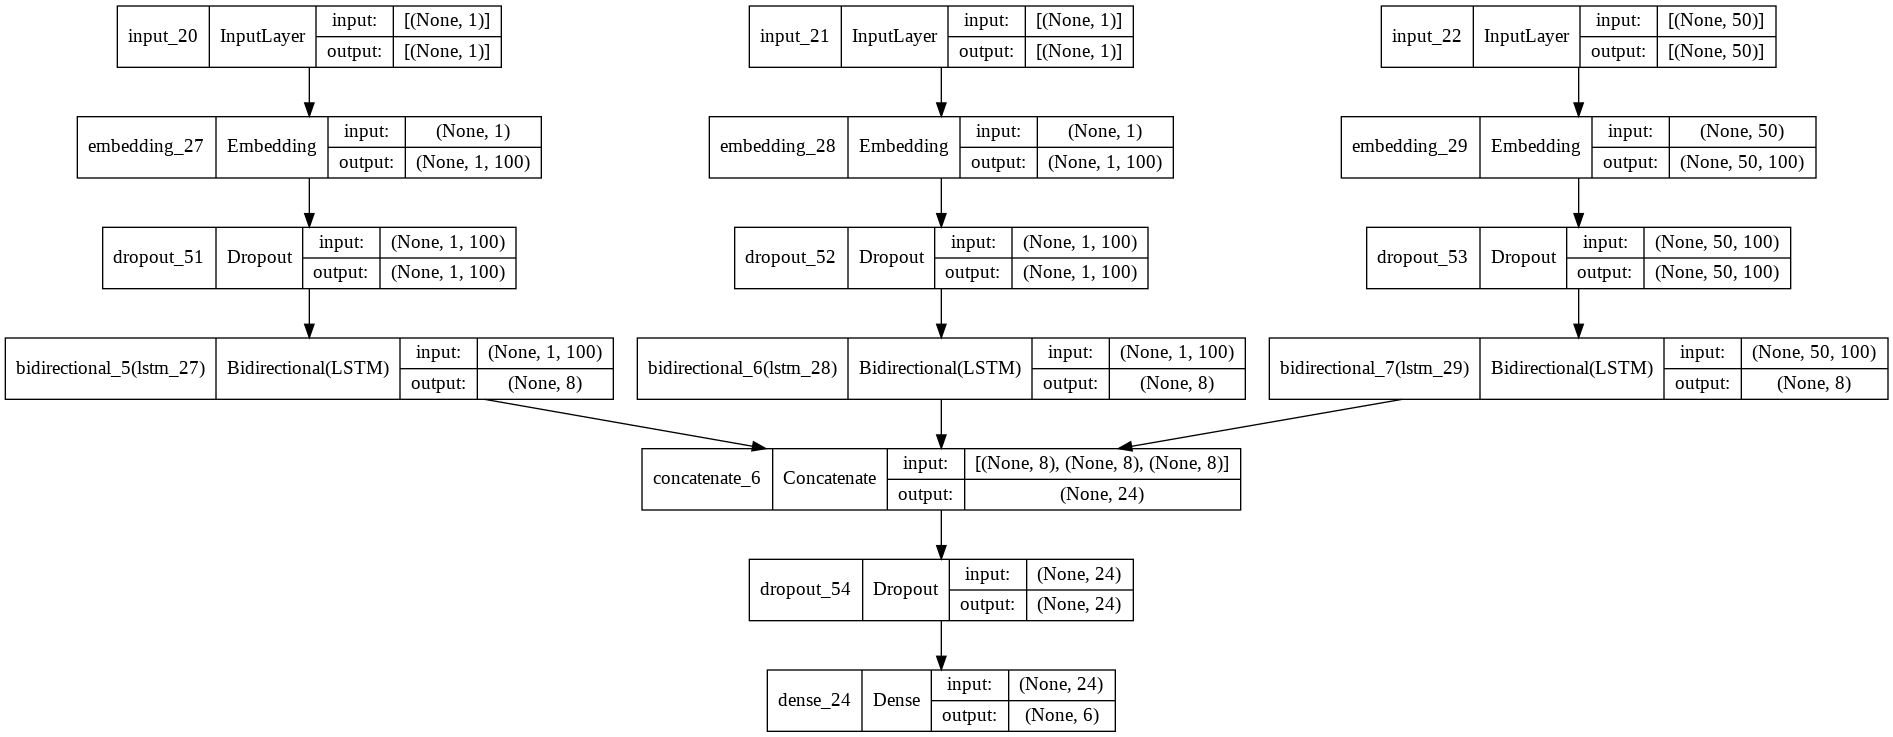

In [136]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [137]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [138]:
history = model.fit(
    [speaker_train, party_train, X_train], 
    y_train, 
    validation_data=[[speaker_valid, party_valid, X_valid], y_valid],
    epochs = 5
)

Epoch 1/5
296/296 [==============================] - 24s 45ms/step - loss: 1.7528 - accuracy: 0.2119 - val_loss: 1.7266 - val_accuracy: 0.2519
Epoch 2/5
296/296 [==============================] - 11s 37ms/step - loss: 1.6798 - accuracy: 0.2749 - val_loss: 1.6922 - val_accuracy: 0.2553
Epoch 3/5
296/296 [==============================] - 11s 36ms/step - loss: 1.5709 - accuracy: 0.3447 - val_loss: 1.7016 - val_accuracy: 0.2587
Epoch 4/5
296/296 [==============================] - 11s 36ms/step - loss: 1.4552 - accuracy: 0.4129 - val_loss: 1.7635 - val_accuracy: 0.2494
Epoch 5/5
296/296 [==============================] - 11s 36ms/step - loss: 1.3507 - accuracy: 0.4579 - val_loss: 1.8240 - val_accuracy: 0.2460


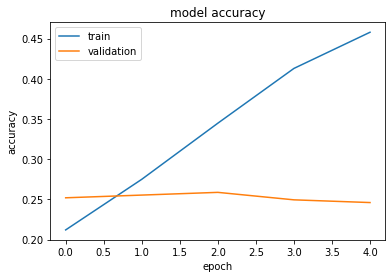

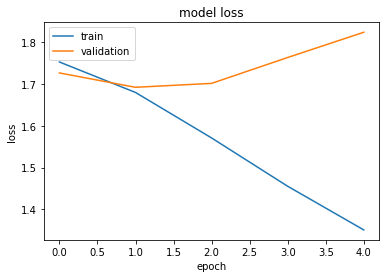

In [139]:
plot_history(history)

In [140]:
score, acc = model.evaluate([speaker_test, party_test, X_test], y_test)
print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 1s 15ms/step - loss: 1.8056 - accuracy: 0.2528
Test score: 1.805564045906067
Test accuracy: 0.2527849078178406


In [141]:
y_probas = model.predict([speaker_test, party_test, X_test])
y_pred = y_probas.argmax(axis=-1)

In [142]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.48      0.17      0.25        83
           1       0.22      0.34      0.27       222
           2       0.21      0.19      0.20       195
           3       0.26      0.28      0.27       246
           4       0.28      0.29      0.29       222
           5       0.28      0.17      0.21       199

    accuracy                           0.25      1167
   macro avg       0.29      0.24      0.25      1167
weighted avg       0.27      0.25      0.25      1167



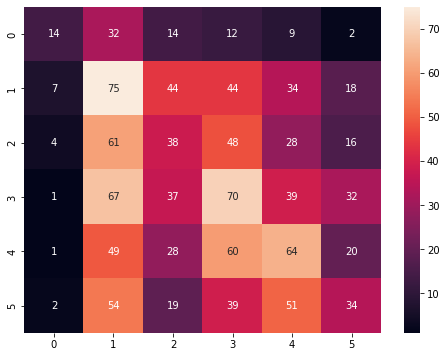

In [143]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Binary

In [80]:
binary = dict()
binary[-3] = 0
binary[-2]=0
binary[-1]=0
binary[1]=1
binary[2]=1
binary[3]=1

In [81]:
y_train = y_train.replace({'label': binary})
y_test = y_test.replace({'label': binary})
y_valid = y_valid.replace({'label': binary})

## Text only

### LSTM

The LSTM model includes:
- a layer of embeddings, 
- Dropout(0.4), 
- LSTM(4), 
- Dropout(0.4), 
- fully connected layer with 100 units and activation function ReLu,
- Dropout(0.5) and fully connected layer with activation function sigmoid. 

LSTM network was trained on full-text data using the first 1200 words of the articles (because of memory limitations).

In [82]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, input_length=50, output_dim=4))
model.add(Dropout(rate=0.4))
model.add(LSTM(units=4))
model.add(Dropout(rate=0.4))
model.add(Dense(units=100,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=2, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 4)             59828     
                                                                 
 dropout_29 (Dropout)        (None, 50, 4)             0         
                                                                 
 lstm_13 (LSTM)              (None, 4)                 144       
                                                                 
 dropout_30 (Dropout)        (None, 4)                 0         
                                                                 
 dense_16 (Dense)            (None, 100)               500       
                                                                 
 dropout_31 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 2)                

In [83]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [84]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=[X_valid, y_valid],
    epochs = 5
)

Epoch 1/5
296/296 [==============================] - 7s 15ms/step - loss: 0.6855 - accuracy: 0.5668 - val_loss: 0.6948 - val_accuracy: 0.5275
Epoch 2/5
296/296 [==============================] - 4s 13ms/step - loss: 0.6705 - accuracy: 0.5833 - val_loss: 0.6619 - val_accuracy: 0.5909
Epoch 3/5
296/296 [==============================] - 4s 13ms/step - loss: 0.6221 - accuracy: 0.6609 - val_loss: 0.6691 - val_accuracy: 0.5943
Epoch 4/5
296/296 [==============================] - 4s 13ms/step - loss: 0.5703 - accuracy: 0.7152 - val_loss: 0.6829 - val_accuracy: 0.6052
Epoch 5/5
296/296 [==============================] - 4s 13ms/step - loss: 0.5148 - accuracy: 0.7607 - val_loss: 0.7147 - val_accuracy: 0.5934


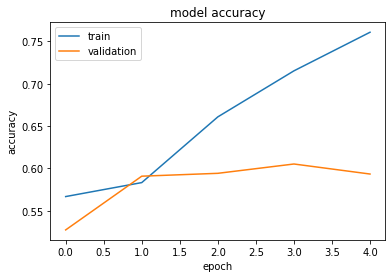

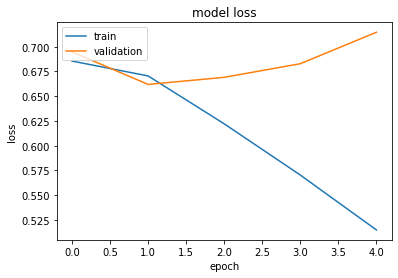

In [85]:
plot_history(history)

In [86]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 0s 6ms/step - loss: 0.7025 - accuracy: 0.6101
Test score: 0.7024708986282349
Test accuracy: 0.6101114153862


In [87]:
y_probas = model.predict(X_test)
y_pred = y_probas.argmax(axis=-1)

In [88]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.55      0.50      0.52       500
           1       0.65      0.69      0.67       667

    accuracy                           0.61      1167
   macro avg       0.60      0.60      0.60      1167
weighted avg       0.61      0.61      0.61      1167



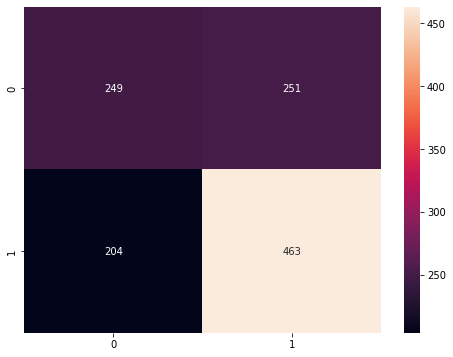

In [89]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Bi-LSTM

The Bi-LSTM model includes:
- a layer of embeddings, 
- Dropout(0.4), 
- Bi-LSTM(4), 
- Dropout(0.4), 
- fully connected layer with 100 units and activation function ReLu,
- Dropout(0.5) and fully connected layer with activation function sigmoid. 

Bi-LSTM network was trained on full-text data using the first 1200 words of the articles (because of memory limitations).

In [90]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, input_length=50, output_dim=4))
model.add(Dropout(rate=0.4))
model.add(Bidirectional(LSTM(units=4)))
model.add(Dropout(rate=0.4))
model.add(Dense(units=100,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=2, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 50, 4)             59828     
                                                                 
 dropout_32 (Dropout)        (None, 50, 4)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 8)                288       
 nal)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 8)                 0         
                                                                 
 dense_18 (Dense)            (None, 100)               900       
                                                                 
 dropout_34 (Dropout)        (None, 100)               0         
                                                      

In [91]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [92]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=[X_valid, y_valid],
    epochs = 5
)

Epoch 1/5
296/296 [==============================] - 12s 28ms/step - loss: 0.6851 - accuracy: 0.5669 - val_loss: 0.6915 - val_accuracy: 0.5275
Epoch 2/5
296/296 [==============================] - 7s 23ms/step - loss: 0.6604 - accuracy: 0.6027 - val_loss: 0.6558 - val_accuracy: 0.5985
Epoch 3/5
296/296 [==============================] - 7s 23ms/step - loss: 0.6089 - accuracy: 0.6723 - val_loss: 0.6668 - val_accuracy: 0.6103
Epoch 4/5
296/296 [==============================] - 7s 23ms/step - loss: 0.5451 - accuracy: 0.7327 - val_loss: 0.7110 - val_accuracy: 0.6019
Epoch 5/5
296/296 [==============================] - 7s 23ms/step - loss: 0.5054 - accuracy: 0.7586 - val_loss: 0.7233 - val_accuracy: 0.5934


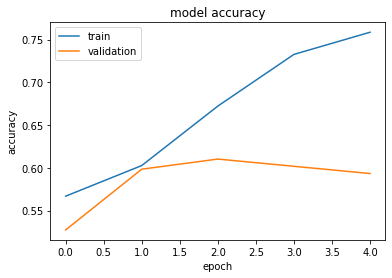

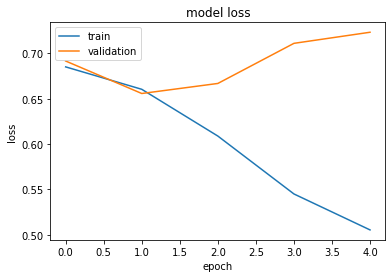

In [93]:
plot_history(history)

In [94]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 0s 10ms/step - loss: 0.7297 - accuracy: 0.5964
Test score: 0.729695737361908
Test accuracy: 0.596401035785675


In [95]:
y_probas = model.predict(X_test)
y_pred = y_probas.argmax(axis=-1)

In [96]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.53      0.52      0.53       500
           1       0.65      0.65      0.65       667

    accuracy                           0.60      1167
   macro avg       0.59      0.59      0.59      1167
weighted avg       0.60      0.60      0.60      1167



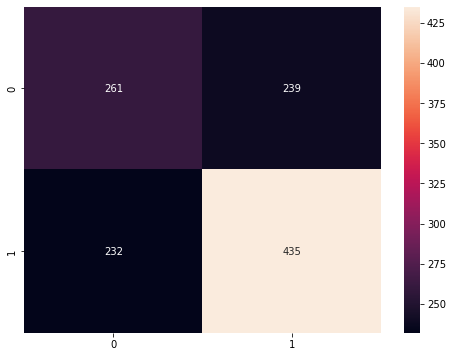

In [97]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Speaker, Party, Text Data

In [98]:
speaker_train = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/speaker_data/train_speaker.csv')
speaker_test = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/speaker_data/test_speaker.csv')
speaker_valid = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/speaker_data/valid_speaker.csv')

In [99]:
party_train = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/party_data/train_party.csv')
party_test = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/party_data/test_party.csv')
party_valid = pd.read_csv('/content/drive/MyDrive/ML_Project/data/liar_dataset/party_data/valid_party.csv')

In [100]:
speaker_vocab_size = max(list(speaker_train['speaker']) + list(speaker_test['speaker']) + list(speaker_valid['speaker']))+1
party_vocab_size = max(list(party_train['party']) + list(party_test['party']) + list(party_valid['party']))+1
text_vocab_size = vocab_size

### LSTM

In [105]:
speaker_input = Input(shape=(1,))
speaker_features = (Embedding(input_dim=speaker_vocab_size, input_length=1, output_dim=100))(speaker_input)
speaker_features = Dropout(rate=0.4)(speaker_features)
speaker_features = LSTM(units=4)(speaker_features)

party_input = Input(shape=(1,))
party_features = (Embedding(input_dim=party_vocab_size, input_length=1, output_dim=100))(party_input)
party_features = Dropout(rate=0.4)(party_features)
party_features = LSTM(units=4)(party_features)

text_input = Input(shape=(50,))
text_features = (Embedding(input_dim=text_vocab_size, input_length=50, output_dim=100))(text_input)
text_features = Dropout(rate=0.4)(text_features)
text_features = LSTM(units=4)(text_features)

x = Concatenate()([speaker_features, party_features, text_features])
x = Dropout(rate=0.5)(x)
model_output = Dense(units=2, activation='sigmoid')(x)

model = Model([speaker_input, party_input, text_input], model_output, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 1, 100)       306600      ['input_11[0][0]']               
                                                                                              

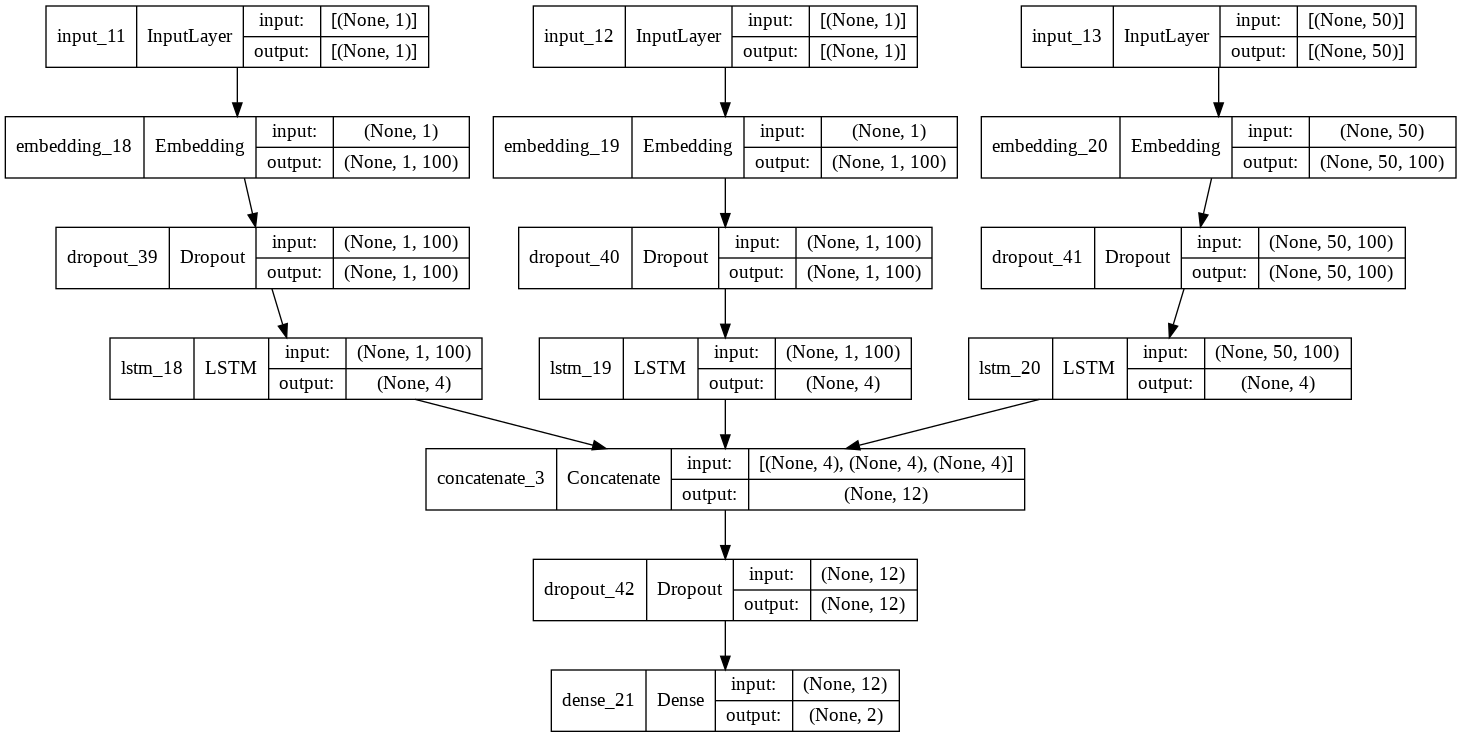

In [106]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [107]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [108]:
history = model.fit(
    [speaker_train, party_train, X_train], 
    y_train, 
    validation_data=[[speaker_valid, party_valid, X_valid], y_valid],
    epochs = 5
)

Epoch 1/5
296/296 [==============================] - 13s 25ms/step - loss: 0.6731 - accuracy: 0.5840 - val_loss: 0.6625 - val_accuracy: 0.5926
Epoch 2/5
296/296 [==============================] - 6s 20ms/step - loss: 0.6216 - accuracy: 0.6657 - val_loss: 0.6435 - val_accuracy: 0.6095
Epoch 3/5
296/296 [==============================] - 6s 20ms/step - loss: 0.5382 - accuracy: 0.7450 - val_loss: 0.6674 - val_accuracy: 0.6171
Epoch 4/5
296/296 [==============================] - 6s 20ms/step - loss: 0.4444 - accuracy: 0.8010 - val_loss: 0.7081 - val_accuracy: 0.6019
Epoch 5/5
296/296 [==============================] - 6s 20ms/step - loss: 0.3609 - accuracy: 0.8444 - val_loss: 0.8000 - val_accuracy: 0.5985


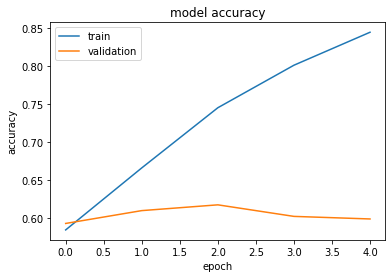

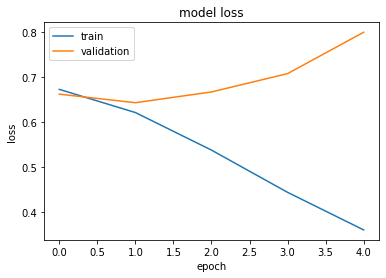

In [109]:
plot_history(history)

In [110]:
score, acc = model.evaluate([speaker_test, party_test, X_test], y_test)
print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 0s 8ms/step - loss: 0.7855 - accuracy: 0.6024
Test score: 0.7854802012443542
Test accuracy: 0.6023992896080017


In [111]:
y_probas = model.predict([speaker_test, party_test, X_test])
y_pred = y_probas.argmax(axis=-1)

In [112]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54       500
           1       0.65      0.65      0.65       667

    accuracy                           0.60      1167
   macro avg       0.59      0.59      0.59      1167
weighted avg       0.60      0.60      0.60      1167



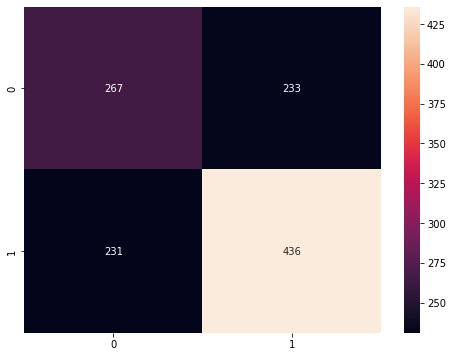

In [113]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Bi-LSTM

In [114]:
speaker_input = Input(shape=(1,))
speaker_features = (Embedding(input_dim=speaker_vocab_size, input_length=1, output_dim=100))(speaker_input)
speaker_features = Dropout(rate=0.4)(speaker_features)
speaker_features = Bidirectional(LSTM(units=4))(speaker_features)

party_input = Input(shape=(1,))
party_features = (Embedding(input_dim=party_vocab_size, input_length=1, output_dim=100))(party_input)
party_features = Dropout(rate=0.4)(party_features)
party_features = Bidirectional(LSTM(units=4))(party_features)

text_input = Input(shape=(50,))
text_features = (Embedding(input_dim=text_vocab_size, input_length=50, output_dim=100))(text_input)
text_features = Dropout(rate=0.4)(text_features)
text_features = Bidirectional(LSTM(units=4))(text_features)

x = Concatenate()([speaker_features, party_features, text_features])
x = Dropout(rate=0.5)(x)
model_output = Dense(units=2, activation='softmax')(x)

model = Model([speaker_input, party_input, text_input], model_output, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 1, 100)       306600      ['input_14[0][0]']               
                                                                                              

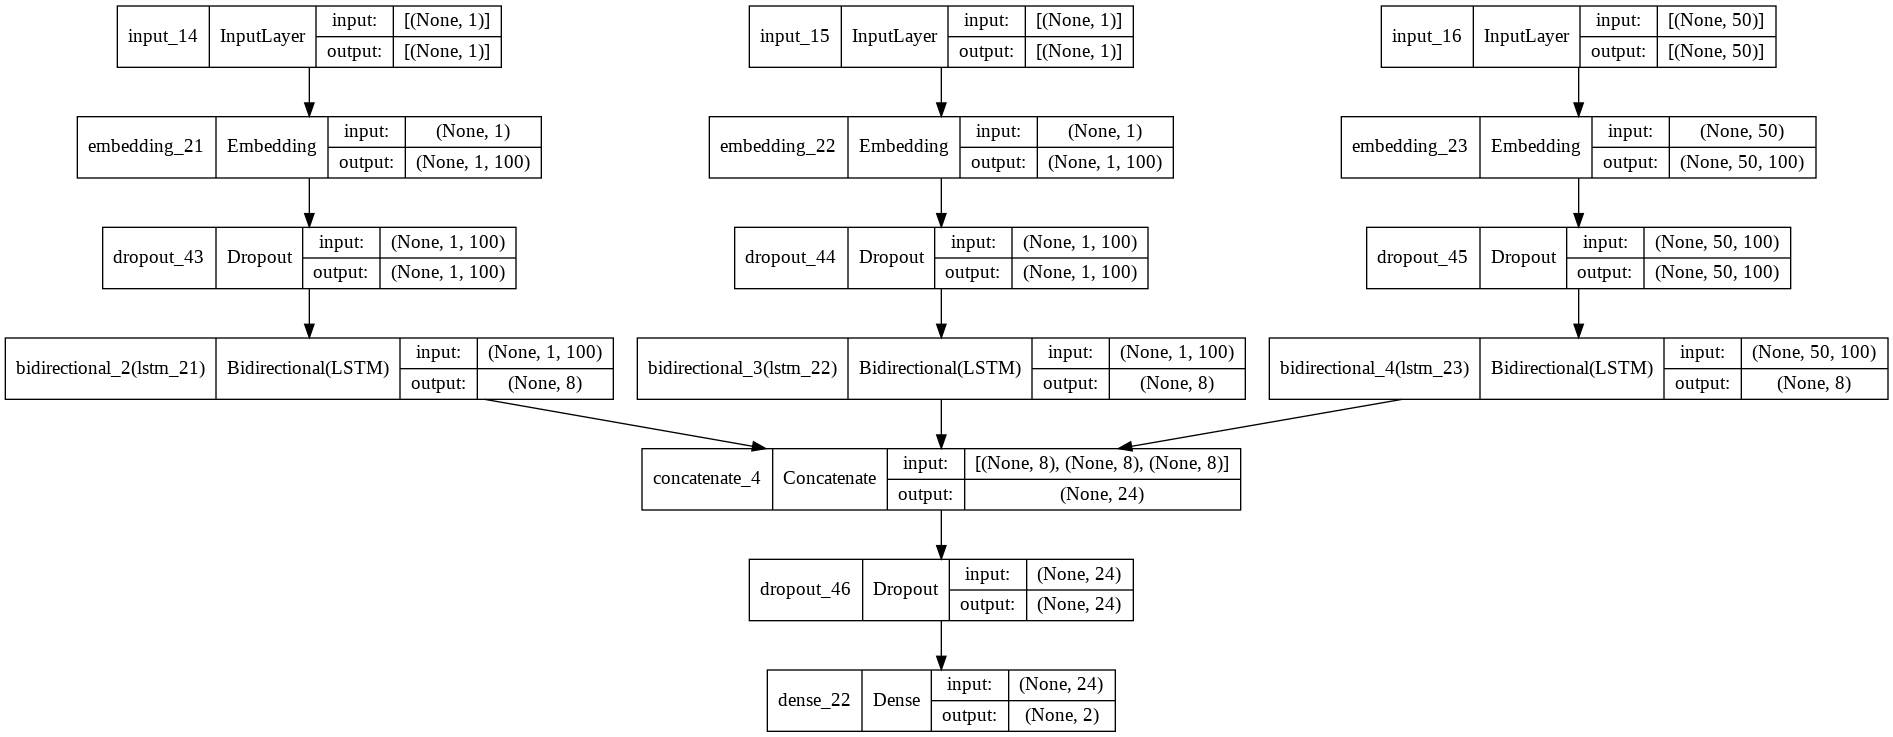

In [115]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [116]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [117]:
history = model.fit(
    [speaker_train, party_train, X_train], 
    y_train, 
    validation_data=[[speaker_valid, party_valid, X_valid], y_valid],
    epochs = 5
)

Epoch 1/5
296/296 [==============================] - 24s 45ms/step - loss: 0.6703 - accuracy: 0.5870 - val_loss: 0.6525 - val_accuracy: 0.6213
Epoch 2/5
296/296 [==============================] - 11s 37ms/step - loss: 0.6002 - accuracy: 0.6884 - val_loss: 0.6433 - val_accuracy: 0.6230
Epoch 3/5
296/296 [==============================] - 11s 36ms/step - loss: 0.4934 - accuracy: 0.7699 - val_loss: 0.6808 - val_accuracy: 0.6052
Epoch 4/5
296/296 [==============================] - 11s 36ms/step - loss: 0.3999 - accuracy: 0.8245 - val_loss: 0.7477 - val_accuracy: 0.5985
Epoch 5/5
296/296 [==============================] - 11s 37ms/step - loss: 0.3359 - accuracy: 0.8601 - val_loss: 0.8098 - val_accuracy: 0.6103


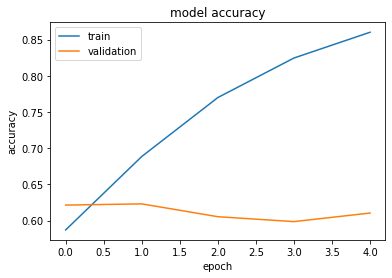

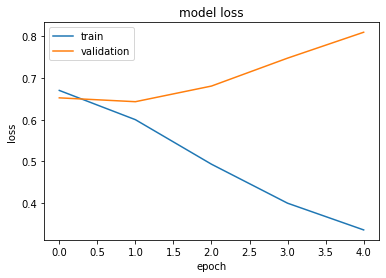

In [118]:
plot_history(history)

In [119]:
score, acc = model.evaluate([speaker_test, party_test, X_test], y_test)
print('Test score:', score)
print('Test accuracy:', acc)

37/37 [==============================] - 1s 16ms/step - loss: 0.8028 - accuracy: 0.6367
Test score: 0.8027849197387695
Test accuracy: 0.636675238609314


In [120]:
y_probas = model.predict([speaker_test, party_test, X_test])
y_pred = y_probas.argmax(axis=-1)

In [121]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.60      0.45      0.52       500
           1       0.65      0.77      0.71       667

    accuracy                           0.64      1167
   macro avg       0.63      0.61      0.61      1167
weighted avg       0.63      0.64      0.63      1167



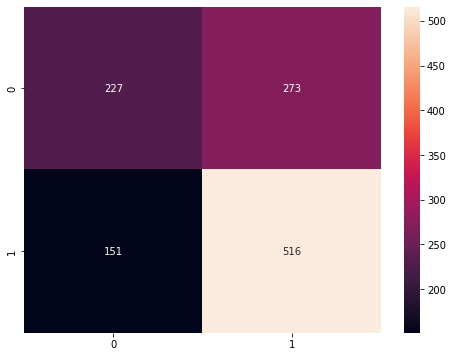

In [122]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()